In [23]:
import sys
import warnings
import gym
import typing
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gym.envs.toy_text.blackjack import sum_hand
from collections import defaultdict
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym import spaces

warnings.filterwarnings('ignore')

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
env.action_space

Discrete(2)

Пространство действий интуитивно понятное:
есть 2 действия 
* hit=1 - взять еще одну карту
* stand=0 - не брать больше карт


In [4]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

Посмотрим на рандомную стратегию

In [6]:
class GameSim:

    def __init__(self, env, strategy, seed=None):
        self.env = env
        self.strategy = strategy
        self.seed = seed or 42
        self.train_rewards = {}
    
    def save_rewards(self, i, n):
        self.train_rewards[i] = self.eval_reward(is_plot_mean=False)


    def plot_rewards(self):
        ax = sns.scatterplot(
            range(len(self.train_rewards)),
            self.train_rewards.values(),
            label=type(self.strategy).__name__,
        )
        ax.set(
            xlabel='Episode',
            ylabel='Average reward'
        )
        plt.legend()
        plt.show()
    
    def generate_episode(self, is_learn=True):
        state = self.env.reset()
        states, actions, rewards = [state], [], [0]
        is_done = False
        while True:
            action = self.strategy(state, is_learn)
            new_state, reward, is_done, info = self.env.step(action)
            if is_learn:
                self.strategy.update(state, new_state, action, reward)
            state = new_state

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if is_done:
              break

        return states, actions, rewards
    
    def reset(self):
        self.env.seed(self.seed)
        self.train_rewards = {}
    
    def fit(self, save_rewards=True, num_episodes=10_000):
        self.reset()
        for i in tqdm(range(num_episodes), desc="fit: "):
            states, actions, rewards = self.generate_episode(is_learn=True)
            
    def eval_reward(self, num_episodes=10_000, is_plot_mean=True):
        total_reward = 0

        mean_rewards = []
        _rewards = []
        for i in tqdm(range(num_episodes), desc='calc reward: '):
            _, _, rewards = self.generate_episode(is_learn=False)
            total_reward += rewards[-1]
            _rewards.append(rewards[-1])

            mean_rewards.append(np.mean(_rewards))

        if is_plot_mean:
            ax = sns.scatterplot(range(len(mean_rewards)), mean_rewards)
            ax.set(
                xlabel="#episodes",
                ylabel="Средний выгрыш",
                title="Динамика среднего выгрыша"
            )
        return total_reward / num_episodes

In [7]:
class SimpleStrategy:
    def __call__(self, state, exploration):
        return state[0] < 19
    
    def update(self, state, new_state, action, reward):
        pass

class RandomStrategy:

    def __init__(self, env):
      self.env = env

    def __call__(self, state, exploration):
      return env.action_space.sample()

    def update(self, state, new_state, action, reward):
      pass

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

-0.213

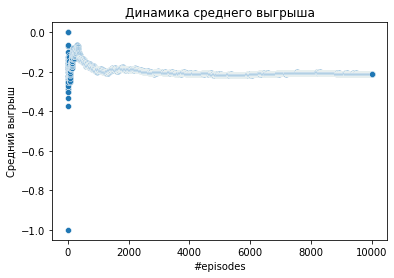

In [8]:
blackjack = GameSim(env, SimpleStrategy())
blackjack.eval_reward()

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

-0.4048

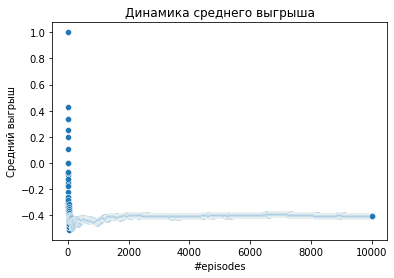

In [9]:
blackjack.strategy = RandomStrategy(env)
blackjack.eval_reward()

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но </br>рекомендую попробовать и другие, например Monte Carlo control) для обучения </br>стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.


In [10]:
class QLearning:


    def __init__(self, env, learning_rate, eps, discount_rate):
        self.env = env
        
        self.learning_rate = learning_rate
        self.eps = eps
        self.discount_rate = discount_rate
        
        self.Q = defaultdict(lambda : np.zeros(env.action_space.n))
        self.policy = defaultdict(int)
        
    def __call__(self, state, exploration=True):
        if np.random.random() <= self.eps and exploration:
            return np.random.randint(self.env.action_space.n)
        return self.policy[state]
    
    def update(self, state, new_state, action, reward):
        self.Q[state][action] += self.learning_rate * (
            reward + self.discount_rate * np.max(self.Q[new_state]) 
            - self.Q[state][action]
        )
        
        self.policy[state] = np.argmax(self.Q[state])

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего </br> дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а </br>лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [11]:
def grid_search(env, game_sim, strategy_cls, grid_params, episodes):
    grid = np.array(np.meshgrid(*grid_params.values())).reshape(len(grid_params), -1).T
    print("GRID:", len(grid))
    best_reward = -1
    best_params = {}
    for i, params in tqdm(enumerate(grid), total=len(grid)):

        params = dict(zip(grid_params.keys(), params))

        strategy = strategy_cls(env, **params)

        game_sim.strategy = strategy
        
        game_sim.fit(num_episodes=episodes)

        reward = game_sim.eval_reward(num_episodes=episodes)
        
        if reward > best_reward:
            best_reward = reward
            best_params = params
    return best_reward, best_params

In [34]:
def find_best_params(env, game_sim, strategy_cls, params, num_episodes=10_000):
    best_reward, best_params = grid_search(
        env, 
        game_sim,
        strategy_cls, 
        params, 
        num_episodes
    )
    print(best_reward, best_params)
    game_sim.strategy = strategy_cls(env, **best_params)

    game_sim.fit(num_episodes=num_episodes)

    game_sim.eval_reward(num_episodes=num_episodes)
    game_sim.plot_rewards()

In [35]:
params = {
    'learning_rate': np.linspace(1e-6, 1e-5, 3),
    'eps': np.linspace(0.7, 0.9, 3), 
    'discount_rate': np.linspace(0.9, 1, 3),
}

GRID: 27


  0%|          | 0/27 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

-0.0518 {'learning_rate': 1e-06, 'eps': 0.9, 'discount_rate': 0.9}


fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

No handles with labels found to put in legend.


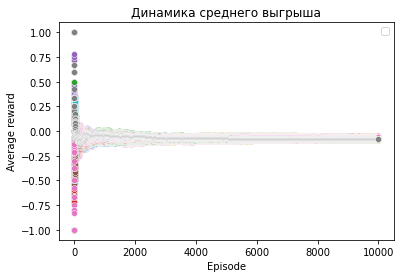

In [14]:
find_best_params(
    env, 
    game_sim=blackjack, 
    strategy_cls=QLearning, 
    params=params, 
    num_episodes=10_000
)

Часть вторая, удвоенная </br>
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли </br>получится. Но, к счастью, на этом история не заканчивается. Описанные выше </br>правила были упрощёнными, а на самом деле у игрока есть ещё и другие </br>возможности. Реализовывать split может оказаться непросто, поэтому давайте </br>ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие: </br>
* double — удвоить ставку; при этом больше действий делать нельзя, игроку </br>выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из </br> 
OpenAI Gym, в котором разрешено удвоение ставки

In [41]:

from gym import spaces


class DoubleBlackjackEnv(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        super(DoubleBlackjackEnv, self).__init__(*args, **kwargs)
        
        self.action_space = spaces.Discrete(3)
        self.reset()
        
    def step(self, action):
        # import pdb; pdb.set_trace()
        assert self.action_space.contains(action)
        reward = max(action, 1)
        res = list(super(DoubleBlackjackEnv, self).step(min(action, 1)))
        if action == 2 and not res[2]:
            res = list(super(DoubleBlackjackEnv, self).step(0))
        res[1] *= reward
        return res

5. Реализуйте метод обучения с подкреплением без модели для этого варианта,  </br> постройте графики, аналогичные п.2.

In [42]:
blackjack = GameSim(env=DoubleBlackjackEnv(), strategy=None)

GRID: 27


  0%|          | 0/27 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

-0.0768 {'learning_rate': 1e-06, 'eps': 0.8, 'discount_rate': 1.0}


fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

No handles with labels found to put in legend.


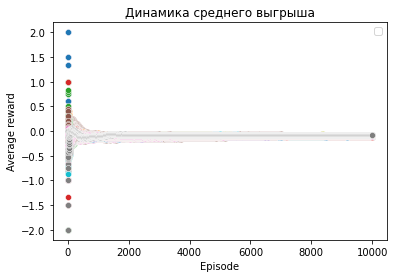

In [43]:
find_best_params(
    env=blackjack.env, 
    game_sim=blackjack, 
    strategy_cls=QLearning, 
    params=params, 
    num_episodes=10_000
)